## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

- Ver. 4.1: 01-May-2023 - Improved plots
- Ver. 4.5: 01-May-2023 - Add Stable-Baselines algo.
- Ver. 4.6: 02-May-2023 - Expt RF vs SB-3 PPO, scaled rewards: 1/10^6 
- Ver. 4.8: 06-May-2023 - Auto run SB3 algos.
- Ver. 5.0: 06-May-2023 - Re-factor. Functions conversions to enable test runs. 

In [16]:
import numpy as np
import pandas as pd

import milling_tool_environment
import utilities
from milling_tool_environment import MillingTool_V2
# from utilities import store_results, plot_learning_curve, single_axes_plot, two_axes_plot, two_variable_plot, plot_error_bounds, test_script, write_test_results
from reinforce_classes import PolicyNetwork, Agent

import datetime
dt = datetime.datetime.now()
dt_d = dt.strftime('%m-%b-%Y')
dt_t = dt.strftime('%H_%M_%S')

In [17]:
import importlib
importlib.reload(milling_tool_environment)
importlib.reload(utilities)

<module 'utilities' from 'D:\\Rajesh\\ResearchLab\\LG_\\utilities.py'>

In [18]:
TRAIN_ROUNDS = 3
# Milling operation constants
WEAR_THRESHOLD = 3.0 # mm
WEAR_THRESHOLD_NORMALIZED = 1.0 # normalized to the max wear threshold
MILLING_OPERATIONS_MAX = 300
ADD_NOISE = 0.0
BREAKDOWN_CHANCE = 0.0

# Policy network learning parameters
gamma = 0.99
alpha = 0.01
EPISODES = 500 # Train for N episodes
PREFIX = f'results_plots/Tool_Wear_{dt_d}_{dt_t}'
DATA_FILE = 'Tool_Wear_VB.csv'
RESULTS_FILE = 'results_plots/test_results.csv'
RF_TRAINING_FILE = f'results_plots/RF_training__{dt_d}_{dt_t}.csv'

In [19]:
## Read data
df = pd.read_csv(DATA_FILE)
df = df[['time', 'VB_mm', 'ACTION_CODE']]

# Normalizing entire df with min-max scaling
WEAR_MIN = df['VB_mm'].min() 
WEAR_MAX = df['VB_mm'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f} \n\n')

## Visualize the data
n_records = len(df.index)
x = df['time'].values.tolist()
y1 = df['VB_mm'].values.tolist()
y2 = df['ACTION_CODE'].values.tolist()

# two_axes_plot(x, y1, y2, title='Tool Wear (mm) data', x_label='Time', y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', xticks=10,threshold=WEAR_THRESHOLD)

Tool wear data imported (121 records). WEAR_THRESHOLD_NORMALIZED: 0.168 




## REINFORCE RL Algorithm

In [20]:
for training_round in range(TRAIN_ROUNDS):
    print(60*'-', f'\n ==== ROUND: {training_round} ====')
    ### Main loop
    rewards_history = []
    loss_history = []

    env = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, ADD_NOISE, BREAKDOWN_CHANCE)

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    agent_RF = Agent(input_dim, output_dim, alpha, gamma)

    for episode in range(EPISODES):
        state = env.reset()

        # Sample a trajectory
        for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
            action = agent_RF.act(state)
            state, reward, done, info = env.step(action)
            agent_RF.rewards.append(reward)
            #env.render()
            if done:
                # print('** DONE **', info)
                break

        # Learn during this episode 
        loss = agent_RF.learn() # train per episode
        total_reward = sum(agent_RF.rewards)

        # Record statistics for this episode
        rewards_history.append(total_reward)
        loss_history.append(loss.item()) # Extract values from list of torch items for plotting

        # On-policy - so discard all data 
        agent_RF.onpolicy_reset()

        if (episode%100 ==0):
            print(f'[{episode:04d}] Loss: {loss:>10.2e} | Reward: {total_reward:>10.2e} | Ep.length: {env.ep_length:04d}')

    # Process results
    eps = [i for i in range(EPISODES)]
    store_results(training_round, eps, rewards_history, env.ep_tool_replaced_history)
    # Create test cases
    test_cases = np.random.randint(0, env.df_length-1, 100)
    test_cases = np.sort(test_cases)

    results = test_script(training_round, df_normalized, 'REINFORCE', EPISODES, env, agent_RF, test_cases, DATA_FILE, RESULTS_FILE)
    write_test_results(results, RESULTS_FILE)

------------------------------------------------------------ 
 ==== ROUND: 0 ====
[0000] Loss:  -1.51e+02 | Reward:  -2.77e+00 | Ep.length: 0300
[0100] Loss:   1.62e+00 | Reward:   3.37e-01 | Ep.length: 0300
[0200] Loss:   5.68e+00 | Reward:   8.99e-01 | Ep.length: 0300
[0300] Loss:   7.41e+00 | Reward:   1.30e+00 | Ep.length: 0300
[0400] Loss:   5.13e+00 | Reward:   1.27e+00 | Ep.length: 0300
REINFORCE algorithm results saved to results_plots/RF_training__05-May-2023_00_05_18.csv
Algo.	Normal	Error	Replace	Error	Overall
	cases		cases		error
--------------------------------------------------
REINFORCE	68	0.000	32	0.312	0.100
--------------------------------------------------
- Test results written to file: results_plots/test_results.csv
------------------------------------------------------------ 
 ==== ROUND: 1 ====
[0000] Loss:  -1.21e+02 | Reward:  -2.12e+00 | Ep.length: 0300
[0100] Loss:   8.70e+00 | Reward:   6.79e-01 | Ep.length: 0300
[0200] Loss:   8.39e+00 | Reward:   1.15e+00 

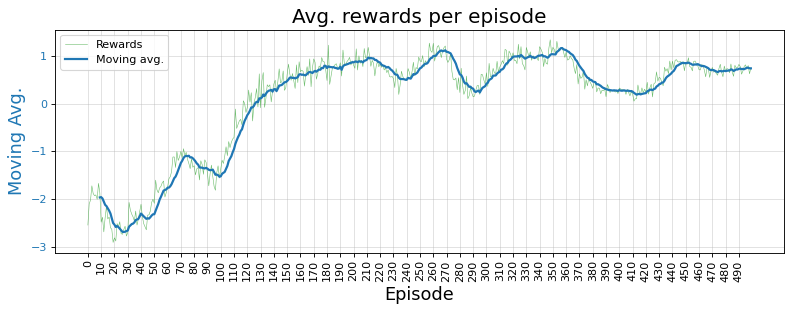

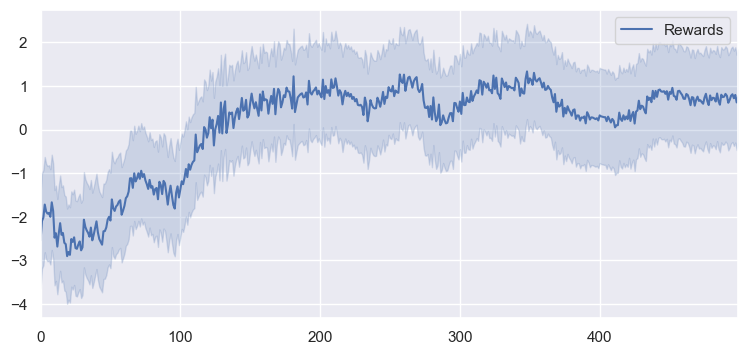

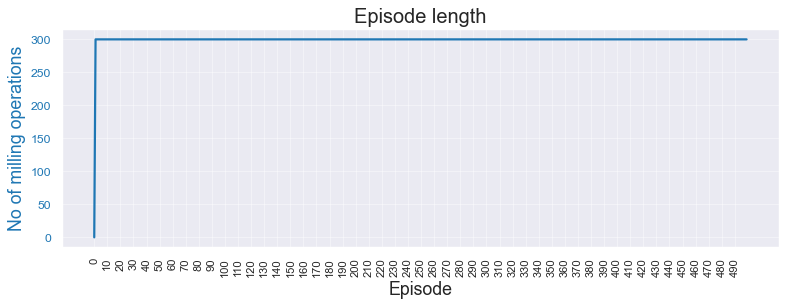

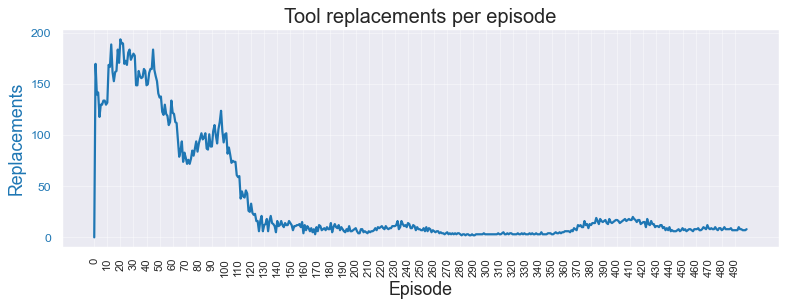

In [21]:
x = [i for i in range(EPISODES)]

## Moving average for rewards
ma_window_size = 10
# # Convert error array to pandas series
rewards = pd.Series(rewards_history)
windows = rewards.rolling(ma_window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
y1 = rewards
y2 = moving_avg_lst

filename = PREFIX + '_Avg_episode_rewards.png'
two_variable_plot(x, y1, y2, 'Avg. rewards per episode', 'Episode', 'Avg. Rewards', 'Moving Avg.', 10, filename)

plot_error_bounds(x, y1)

filename = PREFIX + '_Episode_Length.png'
single_axes_plot(x, env.ep_length_history, 'Episode length', 'Episode', 'No of milling operations', 10, 0.0, filename)

filename = PREFIX + '_Tool_Replacements.png'
single_axes_plot(x, env.ep_tool_replaced_history, 'Tool replacements per episode', 'Episode', 'Replacements', 10, 0.0, filename)

## Stable-Baselines Algorithms

In [22]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

In [23]:
algos = ['A2C','DQN','PPO']
for SB_ALGO in algos:
    if SB_ALGO.upper() == 'A2C': agent_SB = A2C('MlpPolicy', env)
    if SB_ALGO.upper() == 'DQN': agent_SB = DQN('MlpPolicy', env)
    if SB_ALGO.upper() == 'PPO': agent_SB = PPO('MlpPolicy', env)

    for training_round in range(TRAIN_ROUNDS):
        print(f'\n\n{SB_ALGO} - Round {training_round}: Training and Testing Stable-Baselines-3 {SB_ALGO} algorithm')
        agent_SB.learn(total_timesteps=EPISODES)
        results = test_script(training_round, df_normalized, SB_ALGO, EPISODES, env, agent_SB, test_cases, DATA_FILE, RESULTS_FILE)
        write_test_results(results, RESULTS_FILE)



A2C - Round 0: Training and Testing Stable-Baselines-3 A2C algorithm
Algo.	Normal	Error	Replace	Error	Overall
	cases		cases		error
--------------------------------------------------
A2C	58	0.276	42	0.810	0.500
--------------------------------------------------
- Test results written to file: results_plots/test_results.csv


A2C - Round 1: Training and Testing Stable-Baselines-3 A2C algorithm
Algo.	Normal	Error	Replace	Error	Overall
	cases		cases		error
--------------------------------------------------
A2C	58	0.328	42	0.881	0.560
--------------------------------------------------
- Test results written to file: results_plots/test_results.csv


A2C - Round 2: Training and Testing Stable-Baselines-3 A2C algorithm
Algo.	Normal	Error	Replace	Error	Overall
	cases		cases		error
--------------------------------------------------
A2C	58	0.293	42	0.833	0.520
--------------------------------------------------
- Test results written to file: results_plots/test_results.csv


DQN - Round 0: Train